# PAMAP2 - CBAM


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from torchsummary import summary

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/AI_data/PAMAP2/PAMAP2_integrated_data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3850505 entries, 0 to 3850504
Data columns (total 55 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timestamp        float64
 1   activityID       float64
 2   heart_rate       float64
 3   hand_temp        float64
 4   hand_acc_16g_x   float64
 5   hand_acc_16g_y   float64
 6   hand_acc_16g_z   float64
 7   hand_acc_6g_x    float64
 8   hand_acc_6g_y    float64
 9   hand_acc_6g_z    float64
 10  hand_gyro_x      float64
 11  hand_gyro_y      float64
 12  hand_gyro_z      float64
 13  hand_mag_x       float64
 14  hand_mag_y       float64
 15  hand_mag_z       float64
 16  hand_orient_1    float64
 17  hand_orient_2    float64
 18  hand_orient_3    float64
 19  hand_orient_4    float64
 20  chest_temp       float64
 21  chest_acc_16g_x  float64
 22  chest_acc_16g_y  float64
 23  chest_acc_16g_z  float64
 24  chest_acc_6g_x   float64
 25  chest_acc_6g_y   float64
 26  chest_acc_6g_z   float64
 27  chest_gyro_x

In [5]:
df.isna().sum()

,0
timestamp,0
activityID,0
heart_rate,3498952
hand_temp,14338
hand_acc_16g_x,14338
hand_acc_16g_y,14338
hand_acc_16g_z,14338
hand_acc_6g_x,14338
hand_acc_6g_y,14338
hand_acc_6g_z,14338


In [6]:
activity_mapping = {
    1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6,
    12: 7, 13: 8, 16: 9, 17: 10, 24: 11
}
df = df[df["activityID"].isin(activity_mapping.keys())]

# Handle NaN values by activity
df_list = []
for activity_id in df['activityID'].unique():
    activity_df = df[df['activityID'] == activity_id].copy()
    # linear interpolation
    activity_df = activity_df.interpolate(method='linear')
    # NaN 값이 남아 있을 때 forward/backward fill 처리
    activity_df = activity_df.fillna(method='ffill').fillna(method='bfill')
    df_list.append(activity_df)

df_processed = pd.concat(df_list, ignore_index=True)

/tmp/ipython-input-2756959744.py:12: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  activity_df = activity_df.interpolate(method='linear')
/tmp/ipython-input-2756959744.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  activity_df = activity_df.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-2756959744.py:12: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  activity_df = activity_df.interpolate(method='linear')
/tmp/ipython-input-2756959744.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  activity_df = activity_df.fillna(method='ffill').f

In [7]:
df['activityID'].value_counts()

,count
activityID,
4.0,238761
17.0,238690
1.0,192523
3.0,189931
7.0,188107
2.0,185188
16.0,175353
6.0,164600
12.0,117216


In [8]:
train_df = df_processed[~df_processed['subject'].isin(['Protocol_subject101', 'Protocol_subject102'])]
val_df = df_processed[df_processed['subject'] == 'Protocol_subject101']
test_df = df_processed[df_processed['subject'] == 'Protocol_subject102']

print(f"Train subjects: {train_df['subject'].unique()}")
print(f"Val subjects: {val_df['subject'].unique()}")
print(f"Test subjects: {test_df['subject'].unique()}")

Train subjects: ['Protocol_subject103' 'Protocol_subject104' 'Protocol_subject105'
 'Protocol_subject106' 'Protocol_subject107' 'Protocol_subject108'
 'Protocol_subject109']
Val subjects: ['Protocol_subject101']
Test subjects: ['Protocol_subject102']


In [9]:
features_to_scale = df_processed.columns.drop(['subject', 'activityID'])

scaler = MinMaxScaler()

# train 데이터에만 fit
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

# val/test는 train의 scaler로 transform만 적용
val_df[features_to_scale]  = scaler.transform(val_df[features_to_scale])
test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

/tmp/ipython-input-2095711556.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
/tmp/ipython-input-2095711556.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[features_to_scale]  = scaler.transform(val_df[features_to_scale])
/tmp/ipython-input-2095711556.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [10]:
TIME_STEPS = 100 # 1 sec (100Hz sampling)
STEPS = 50       # 50% overlap

def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        # 최빈값(activityID) 라벨 선택
        ys.append(stats.mode(labels, keepdims=True)[0][0])
        Xs.append(x)
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [11]:
def prepare_data_split(df):
    X = df.drop(columns=['activityID', 'subject'])
    y = df['activityID'].map(activity_mapping)
    X_seq, y_seq = create_dataset(X, y, TIME_STEPS, STEPS)
    return X_seq, y_seq.flatten()

In [12]:
X_train, y_train = prepare_data_split(train_df)
X_val, y_val     = prepare_data_split(val_df)
X_test, y_test   = prepare_data_split(test_df)

print(f"\nSubject-based data split:")
print(f"Train set size: X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"Validation set size: X_val.shape = {X_val.shape}, y_val.shape = {y_val.shape}")
print(f"Test set size: X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")


Subject-based data split:
Train set size: X_train.shape = (28590, 100, 53), y_train.shape = (28590,)
Validation set size: X_val.shape = (4998, 100, 53), y_val.shape = (4998,)
Test set size: X_test.shape = (5265, 100, 53), y_test.shape = (5265,)


In [13]:
class PAMAP2Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [14]:
train_dataset = PAMAP2Dataset(X_train, y_train)
val_dataset = PAMAP2Dataset(X_val, y_val)
test_dataset = PAMAP2Dataset(X_test, y_test)

In [15]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# 1D 채널 어텐션 모듈
class ChannelAttention1D(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention1D, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        # 1x1 Conv를 사용한 공유 MLP 구현
        self.shared_mlp = nn.Sequential(
            nn.Conv1d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_mlp(self.avg_pool(x))
        max_out = self.shared_mlp(self.max_pool(x))
        # avg_out + max_out 후 sigmoid 적용
        attention_map = self.sigmoid(avg_out + max_out)
        # 원본 입력 x와 채널별 가중치 맵을 곱함 (브로드캐스팅)
        return x * attention_map.expand_as(x)

In [17]:
# 1D 공간 어텐션 모듈
class SpatialAttention1D(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention1D, self).__init__()
        # 'same' 패딩을 위해 커널 크기는 홀수여야 함
        assert kernel_size % 2 == 1, "Kernel size must be odd"
        padding = (kernel_size - 1) // 2

        # 채널(avg, max)을 따라 concat된 2개 채널을 1개로 줄이는 Conv
        self.conv = nn.Conv1d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 채널 차원으로 풀링 (dim=1)
        avg_out = torch.mean(x, dim=1, keepdim=True) # (B, 1, L)
        max_out, _ = torch.max(x, dim=1, keepdim=True) # (B, 1, L)

        # 두 맵을 채널 차원으로 연결
        concatenated = torch.cat([avg_out, max_out], dim=1) # (B, 2, L)

        # Conv 연산 및 Sigmoid
        attention_map = self.sigmoid(self.conv(concatenated)) # (B, 1, L)
        # 원본 입력 x와 공간별 가중치 맵을 곱함 (브로드캐스팅)
        return x * attention_map.expand_as(x)

In [18]:
# 1D CBAM 모듈 (채널 -> 공간 순차 적용)
class CBAM1D(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM1D, self).__init__()
        self.channel_attention = ChannelAttention1D(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention1D(kernel_size)

    def forward(self, x):
        # 채널 어텐션 적용
        x_refined = self.channel_attention(x)
        # 공간 어텐션 적용
        x_final = self.spatial_attention(x_refined)
        return x_final

In [19]:
class BasicBlock1D_CBAM(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction_ratio=16):
        super(BasicBlock1D_CBAM, self).__init__()

        # 3x1 합성곱 -> 배치 정규화 -> ReLU
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        # 3x1 합성곱 -> 배치 정규화
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        # 잔차 연결 직전에 CBAM 적용
        self.cbam = CBAM1D(out_channels, reduction_ratio)

        # Shortcut 경로 (Stride가 1이 아니거나 입력/출력 채널 수가 다를 때 차원 맞춰주기)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.cbam(out)
        out += shortcut
        out = self.relu(out)
        return out

In [23]:
class ResNet1D_CBAM(nn.Module):
    def __init__(self, num_classes, input_channels):
        super(ResNet1D_CBAM, self).__init__()
        self.in_channels = 64 # Stem 통과 후 채널 수

        # Stem
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # ResNet
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)

        # 3. Classifier
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(BasicBlock1D_CBAM(in_channels, out_channels, stride=stride))
        for _ in range(1, blocks):
            layers.append(BasicBlock1D_CBAM(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.global_pool(x)
        x = x.squeeze(-1)
        x = self.dropout(x)

        output = self.classifier(x)
        return output

In [24]:
input_features = X_train.shape[2]
num_classes = len(np.unique(y_train))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = ResNet1D_CBAM(num_classes, input_features).to(device)

summary(model, input_size=(TIME_STEPS, input_features))

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 50]          23,744
       BatchNorm1d-2               [-1, 64, 50]             128
              ReLU-3               [-1, 64, 50]               0
         MaxPool1d-4               [-1, 64, 25]               0
            Conv1d-5               [-1, 64, 25]          12,288
       BatchNorm1d-6               [-1, 64, 25]             128
              ReLU-7               [-1, 64, 25]               0
            Conv1d-8               [-1, 64, 25]          12,288
       BatchNorm1d-9               [-1, 64, 25]             128
AdaptiveAvgPool1d-10                [-1, 64, 1]               0
           Conv1d-11                 [-1, 4, 1]             256
             ReLU-12                 [-1, 4, 1]               0
           Conv1d-13                [-1, 64, 1]             256
AdaptiveMaxPool1d-14

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=1e-5)

In [26]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [27]:
num_epochs = 100
best_val_loss = float('inf')
patience = 20
patience_counter = 0

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

print("Starting training...")
for epoch in range(num_epochs):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'PAMAP2_CNN_best.pth')
        print(f'New best validation loss: {best_val_loss:.2f}%')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

print("Training completed!")

Starting training...
Epoch [1/100]
Train Loss: 0.3922, Train Acc: 87.86%
Val Loss: 5.3194, Val Acc: 36.25%
--------------------------------------------------
New best validation loss: 5.32%
Epoch [2/100]
Train Loss: 0.1459, Train Acc: 95.69%
Val Loss: 1.7107, Val Acc: 58.76%
--------------------------------------------------
New best validation loss: 1.71%
Epoch [3/100]
Train Loss: 0.1028, Train Acc: 97.02%
Val Loss: 3.9056, Val Acc: 48.58%
--------------------------------------------------
Epoch [4/100]
Train Loss: 0.0884, Train Acc: 97.40%
Val Loss: 4.2871, Val Acc: 47.14%
--------------------------------------------------
Epoch [5/100]
Train Loss: 0.0775, Train Acc: 97.75%
Val Loss: 5.1822, Val Acc: 41.62%
--------------------------------------------------
Epoch [6/100]
Train Loss: 0.0555, Train Acc: 98.40%
Val Loss: 4.3673, Val Acc: 47.22%
--------------------------------------------------
Epoch [7/100]
Train Loss: 0.0576, Train Acc: 98.31%
Val Loss: 3.5410, Val Acc: 63.77%
-------

In [28]:
model.load_state_dict(torch.load('PAMAP2_CNN_best.pth'))

print("\nFinal Evaluation:")
train_loss, train_acc = validate_epoch(model, train_loader, criterion, device)
print(f"Training accuracy: {train_acc:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f"Test accuracy: {test_acc:.2f}%")
print(f"Test loss: {test_loss:.4f}")


Final Evaluation:
Training accuracy: 95.31%
Training loss: 0.1440
Test accuracy: 57.85%
Test loss: 1.7327


In [29]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9573    0.9782       468
           1     0.9220    0.4497    0.6045       447
           2     0.4685    0.1309    0.2046       512
           3     0.1667    0.0461    0.0722       651
           4     0.2998    1.0000    0.4613       185
           5     0.4561    0.9841    0.6233       502
           6     0.6201    0.7391    0.6743       594
           7     0.8347    0.5677    0.6758       347
           8     1.0000    0.0691    0.1292       304
           9     0.5067    1.0000    0.6726       414
          10     0.6932    0.9515    0.8020       577
          11     0.5000    0.0038    0.0075       264

    accuracy                         0.5785      5265
   macro avg     0.6223    0.5749    0.4921      5265
weighted avg     0.6110    0.5785    0.5120      5265



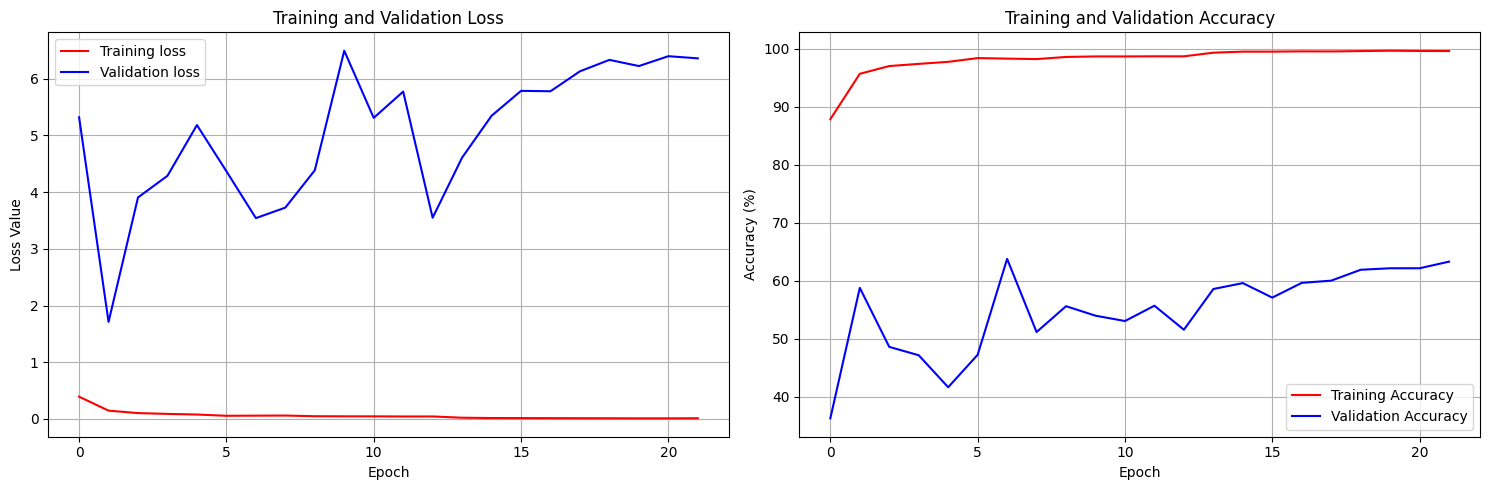

In [30]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'r', label='Training loss')
plt.plot(val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'r', label='Training Accuracy')
plt.plot(val_accuracies, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

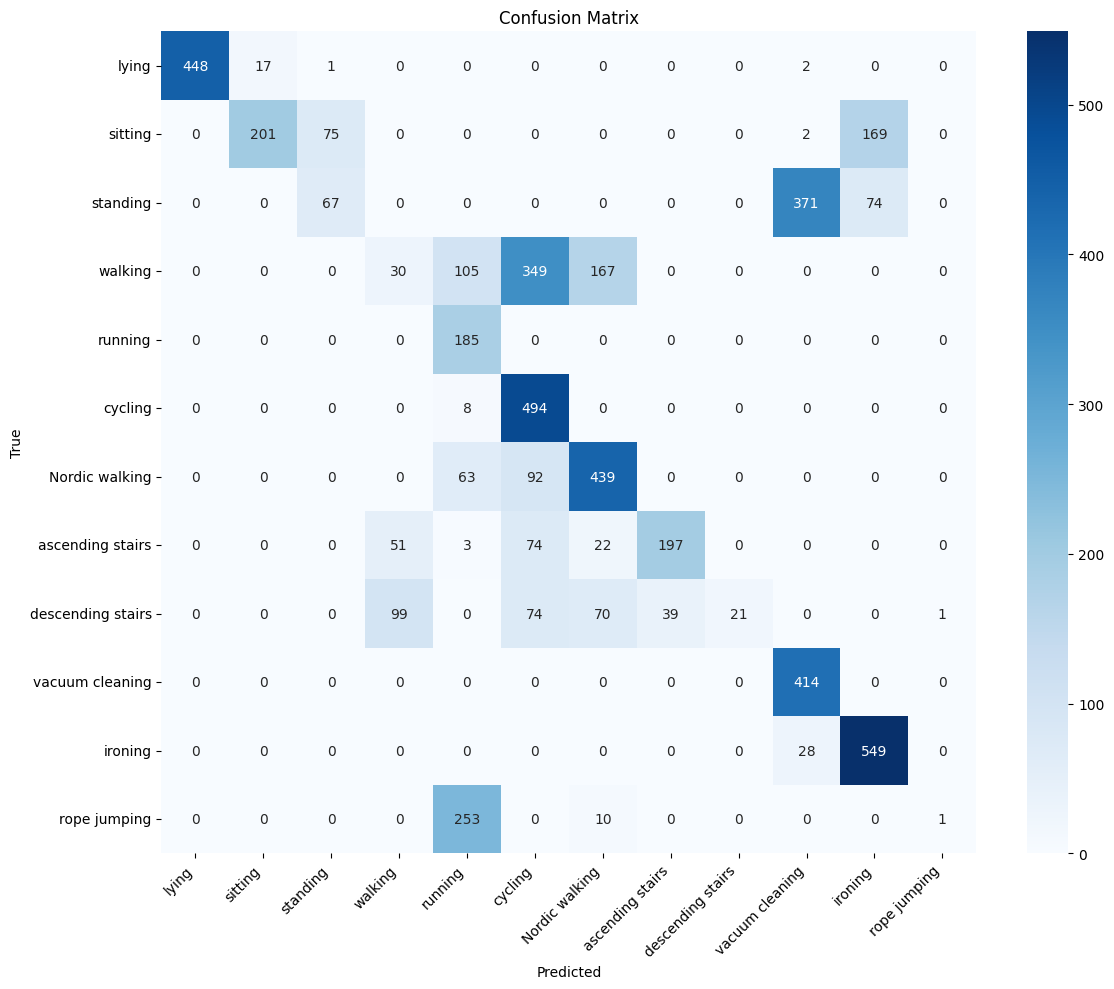

In [31]:
LABELS = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling',
          'Nordic walking', 'ascending stairs', 'descending stairs',
          'vacuum cleaning', 'ironing', 'rope jumping']

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

if num_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:num_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:num_classes], rotation=0)

plt.tight_layout()
plt.show()